# Analysis of the error messages and creation of the word embeddings

In [1]:
import nltk
import pandas as pd
import numpy as np
import gensim
import itertools
from collections import Counter

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [3]:
from nltk.tokenize.treebank import TreebankWordTokenizer #word_tokenize
from nltk.tokenize import word_tokenize

## 1. Read the data and clean up the text

In [4]:
df_msg = pd.read_csv('/eos/user/l/llayer/AIErrorHandling/df_error_msg_exitcodes.csv')

In [5]:
# Tokenize the text
t = TreebankWordTokenizer()
df_msg['tokenized_text'] = df_msg['error_msg'].apply(t.tokenize)

In [6]:
def get_frequencies(df, col_name):
    # Count the word occurences
    str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*df[col_name]
                                                                            )))).items()),columns=['word','count'])
    return str_frequencies.sort_values(by ='count',ascending=False  )

In [7]:
def get_counts(df, col_name):
    
    # Count the word occurences
    str_frequencies = Counter(filter(None,list(itertools.chain(*df[col_name]))))
    return str_frequencies  

In [8]:
str_frequencies = get_frequencies(df_msg, 'tokenized_text')

In [9]:
str_frequencies.head()

,word,count
46952,:,3035524
179785,>,2436527
113534,<,2343766
211512,--,1980127
526351,",",1918411


In [10]:
minimum_count = 5
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])

In [11]:
import string 
# Remove punctuation and kick out words that occur less than a certain threshold
def check_first_and_last_char(word):
    if word[0] in "':/.-": 
        #print word
        word = word.replace(word[0], '')
        #print word
    if len(word) > 1:
        if word[-1] in "':/.-": 
            word = word.replace(word[-1], '')
    return word

# Remove punctuation and kick out words that occur less than a certain threshold
def clean_data(tokens):
    words = filter(lambda word: word not in '``#\'"\'\'|==,|--$;:=+><[!@]|&?{}...%(.)""()==========' and word not in low_frequency_words, tokens)
    words_cleaned = [check_first_and_last_char(word) for word in words]
    #words_cleaned = filter(lambda word: word.isalpha() == False, words_cleaned)
    words_cleaned = filter(lambda word: word not in 'abcdefghijklmnopqrstuvwxyzn=', words_cleaned)
    return words_cleaned

In [12]:
df_msg['tokenized_text_filtered'] = df_msg['tokenized_text'].apply(clean_data)
#res = test['tokenized_text_filtered'].agg('sum')

In [13]:
tokens = df_msg.iloc[207]
print 'Original message'
print
print tokens["error_msg"]
print
"""
print 'Tokenized'
print
print tokens["tokenized_text"]
print
"""
print 'Filtered'
print
print tokens["tokenized_text_filtered"]

Original message

Adding last 25 lines of CMSSW stdout:   734 PFEGammaAlgo::mergeROsByAnyLink 1/115407         1/115529         1/118126   735 PFTrackTransformer   1/115277         1/115277         1/118020   736 PFTrackTransformer   1/115277         1/115277         1/118020   737 RecoMuon             1/115516         1/117754         1/118143   738 XrdAdaptor           pre-events                           739 XrdAdaptorInternal   pre-events       pre-events       pre-events   740 XrdFileWarning       pre-events                           741 FailedPropagation    1/115534                             742 TimeReport           PostGlobalEndRun                     743 TrajectoryNotPosDef  1/115282                             744 Fatal Exception      AfterSource                          745 Fatal Exception      1/118162         1/118154         1/118166   746 MemoryReport         PostGlobalEndRun                     747 fileAction           PostGlobalEndRun                     748 fileActio

In [14]:
str_frequencies_filtered = get_frequencies(df_msg, 'tokenized_text_filtered')

In [15]:
pd.set_option('display.max_rows', 100)
str_frequencies_filtered.head(100)

,word,count
37539,file,263688
17565,edm,221135
8038,0,189748
22045,is,174509
40472,1,174478
10471,Total,172257
8130,KB/sec,162434
26706,of,161441
49482,Exception,145954
22052,in,144281


In [16]:
most_freq = str_frequencies_filtered['word'][0:100]

In [17]:
out = df_msg.drop([ 'error_msg', 'side_state','action', 'memory', 'tokenized_text' ], axis = 1)

In [14]:
out.to_csv('filtered_msg.csv')

## 2. Analyze the filtered words

In [14]:
counts = get_counts(df_msg, 'tokenized_text_filtered')

In [15]:
type(counts)

collections.Counter

In [47]:
import wordcloud
import matplotlib.pyplot as plt

In [92]:
wc = wordcloud.WordCloud(max_words=100, background_color="white", width=1200, height=800).generate_from_frequencies(counts)

In [48]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random_state.randint(0, 1000) / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [49]:
wordcloud = wordcloud.WordCloud(width=1600, height=800, color_func=random_color_func, background_color="white", max_words=100).generate_from_frequencies(counts)

In [ ]:
# Save the image in the img folder:
wordcloud.to_file("img/first_review.png")

In [51]:
#plt.figure( figsize=(20,10), facecolor='k')
plt.figure( figsize=(24,14), dpi=1200)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

Text(0,0.5,'Number of workflows')

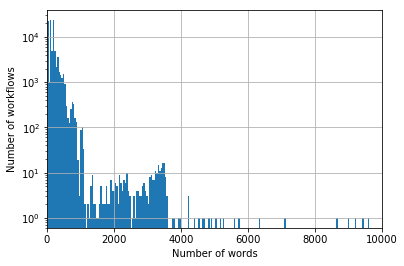

In [20]:
import matplotlib.pyplot as plt
ax = df_msg['tokenized_text_filtered'].apply(lambda x: len(x)).hist(bins = 1000)
plt.xlim([0,10000])
ax.set_yscale('log')
ax.set_xlabel('Number of words')
ax.set_ylabel('Number of workflows')

## 3.0. Load the google model and inspect

In [17]:
from gensim.models import KeyedVectors

In [18]:
model = KeyedVectors.load_word2vec_format('..//..//GoogleNews-vectors-negative300.bin', binary=True)

In [23]:
words_in = 0
words_out = 0
for w in list(str_frequencies_filtered['word']):
    if w not in model:
        words_out += 1
        #print w
    else:
        words_in += 1
print words_in, words_out

1796 55571


In [28]:
# Number of tokens:
print 'Number of tokens', len(list(str_frequencies['word']))
print 'Number of tokens filtered', len(list(str_frequencies_filtered['word']))
print 'Fraction in Google News Model', "%.2f" % (float(words_in) / float(words_in + words_out))

Number of tokens 950252
Number of tokens filtered 57367
Fraction in Google News Model 0.03


In [29]:
words_in = 0
words_out = 0
words = [word.lower() for word in list(str_frequencies_filtered['word'])]
print words[0:100]

['file', 'edm', '0', 'is', '1', 'total', 'kb/sec', 'of', 'exception', 'in', 'to', 'cmssw', 'error', 'none', 'error', 'wmexception', 'root', 'the', 'cmsrun', 'message', 'end', 'open', 'adding', 'bytes', 'gsiftp', 'not', 'line', 'avg', 'inst', 'utc', 'monitor', 'file', 'running', 'status', '25', 'job', 'no', '2', 'job', 'last', 'event', 'traceback', 'error', 'message', 'exception', 'linenumber', 'errornr', 'classname', 'filename', 'classinstance', 'modulename', 'methodname', 'lines', 'start', 'class', '92', 'at', 'srvjobwmtaskspacecmsrun1premixrawoutput.root', 'stdout', 'from', '__init__', 'const', '18', 'id', 'calling', 'process', 'complete', 'begin', 'code', 'event', 'pset.py', 'data', 'fatal', 'frameworkjobreport.xml', 'scramv1', 'arguments', '00:00:00', '85', 'run', '/bin/bash', 'return', 'cmsrunfailure', 'pre-events', 'constructing', 'source', 'has', 'summary', 'wmcore.wmspec.steps.wmexecutionfailure', 'for', 'with', 'loop', 'slc6_amd64_gcc630', 'time', 'eventprincipal', 'srvjobwmco

In [30]:
import pickle
with open('words.pkl', 'wb') as f:
    pickle.dump(words, f)

In [82]:
for w in set(list(words)):
    if w not in model:
        words_out += 1
        #print w
    else:
        words_in += 1
print words_in, words_out

6139 222120


## 3. Train the word2vec model and visualize with tsne

In [27]:
texts_stemmed = list(df_msg['tokenized_text_filtered'])
w2v_sg = gensim.models.Word2Vec(texts_stemmed, size=100, window=5, min_count=5, workers=4, sg=1)
w2v_cbow = gensim.models.Word2Vec(texts_stemmed, size=100, window=5, min_count=5, workers=4, sg=0)

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [79]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in most_freq:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

### Analyze skip-gram

/usr/local/bin/start_ipykernel.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


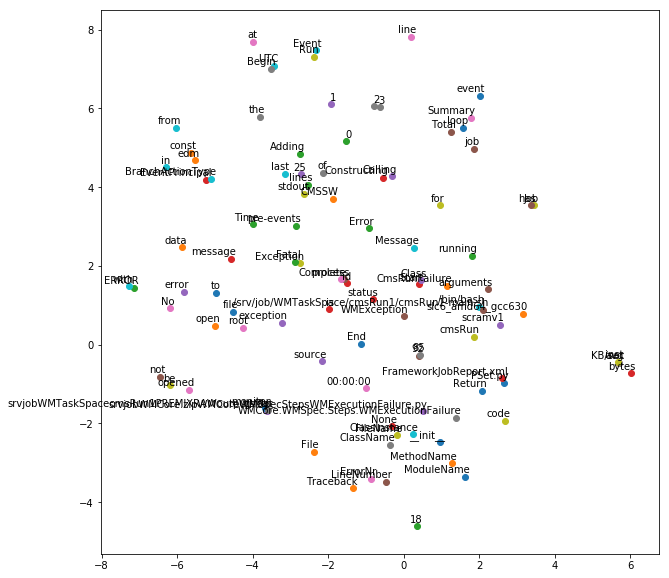

In [80]:
tsne_plot(w2v_sg)

In [21]:
df_msg.head()

,task_name,site,error,error_msg,side_state,action,memory,tokenized_text,tokenized_text_filtered
0,/fabozzi_Run2016D-07Aug17-v1-SingleElectron-17...,T1_US_FNAL_Disk,85,Adding last 25 lines of CMSSW stdout: 775 fi...,bad_site,acdc,NaN,"[Adding, last, 25, lines, of, CMSSW, stdout, :...","[Adding, last, 25, lines, of, CMSSW, stdout, 7..."
1,/fabozzi_Run2017B-v1-DoubleMuon-09Oct2017_940p...,T1_RU_JINR,92,Adding last 25 lines of CMSSW stdout: %MSG-w X...,good_site,acdc,NaN,"[Adding, last, 25, lines, of, CMSSW, stdout, :...","[Adding, last, 25, lines, of, CMSSW, stdout, M..."
2,/fabozzi_Run2017F-v1-DoubleEG-17Nov2017_940_17...,T2_UK_London_Brunel,99109,Error in StageOut: 99109 <@========== WMExcept...,good_site,acdc,NaN,"[Error, in, StageOut, :, 99109, <, @, ========...","[Error, in, StageOut, 99109, WMException, Star..."
3,/fabozzi_Run2017F-v1-DoubleMuon-09May2018_947_...,T2_US_MIT,8004,An exception of category 'BadAlloc' occurred w...,good_site,acdc,180000.0,"[An, exception, of, category, 'BadAlloc, ', oc...","[An, exception, of, category, BadAlloc, occurr..."
4,/fabozzi_Run2017H-v1-FSQJet2-17Nov2017_944_180...,T2_US_Nebraska,92,Adding last 25 lines of CMSSW stdout: [2018-04...,good_site,acdc,NaN,"[Adding, last, 25, lines, of, CMSSW, stdout, :...","[Adding, last, 25, lines, of, CMSSW, stdout, 2..."


In [36]:
# Get TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy(doc):
    return doc
tfidf = TfidfVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,)
x = tfidf.fit_transform(df_msg['tokenized_text_filtered'])
word_weights = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [37]:
def get_average_vector(text):
    return np.mean(np.array([w2vmodel_stemmed.wv[w] for w in text if w in w2vmodel_stemmed]), axis=0)

In [38]:
def get_average_vector_tfidf(text): 
    return np.mean(np.array([w2vmodel_stemmed.wv[w] * word_weights[w] for w in text if w in w2vmodel_stemmed]), axis=0)

In [39]:
df_msg['w2v_tfidf'] = df_msg['tokenized_text_filtered'].apply(get_average_vector_tfidf)

/usr/local/bin/start_ipykernel.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':


In [40]:
df_msg['w2v'] = df_msg['tokenized_text_filtered'].apply(get_average_vector)

/usr/local/bin/start_ipykernel.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':


In [51]:
type(text_vecs)

pandas.core.series.Series

In [41]:
clone_docs = df_msg[(df_msg['action'] == 'clone')].sample(3000)
acdc_docs = df_msg[(df_msg['action'] == 'acdc')].sample(3000)

In [42]:
test_docs = pd.concat([clone_docs, acdc_docs])

In [43]:
print len(test_docs)

6000


In [44]:
import matplotlib.cm as cm

In [52]:
def tsne_plot_classes(model, df, col):
    "Creates and TSNE model and plots it"

    avg_vec = list(df[col])
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(list(avg_vec))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
           
    return x,y

In [51]:
x_w2v_sg, y_w2v_sg = tsne_plot_classes(w2v_sg, test_docs, 'w2v')

{8001: 7, 50660: 2, 99109: 8, 99303: 5, 50664: 4, 73: 6, 139: 3, 85: 1, 99401: 9, 92: 0}
10 10


<Figure size 1152x1152 with 0 Axes>

In [53]:
x_w2v_tfidf_sg, y_w2v_tfidf_sg = tsne_plot_classes(w2v_sg, test_docs, 'w2v_tfidf')

In [76]:
def plot_tsne(df, x, y, title):
    
    labels = df['action']
    error_codes = df['error']
    error_codes_unique = list(df.groupby('error').size().reset_index(name='size').sort_values(by ='size',ascending=False  )['error'][0:10])
    error_colors = {}
    for counter, code in enumerate(error_codes_unique):
        error_colors[code] = counter
    print error_colors
    
    colors = cm.rainbow(np.linspace(0, 1, len(error_codes_unique)))    
    
    print len(colors), len(error_codes_unique)
    plt.figure(figsize=(10, 10)) 
    
    legend = []
    for i in range(len(x)):

        error_code = error_codes.iloc[i]
        if error_code not in error_codes_unique:
            continue
        color = error_colors[error_code]
        if error_code not in legend:
            #print error_code, color
            plt.scatter(x[i],y[i], c=colors[color], label = str(error_code))
            legend.append(error_code)
        else:
            plt.scatter(x[i],y[i], c=colors[color])

        """
        if labels.iloc[i] == 'acdc':
            plt.scatter(x[i],y[i], c='red')
        else:
            plt.scatter(x[i],y[i], c='blue')

        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        """
        
    
    plt.legend(loc='upper right')   
    plt.title(title)
        
    
    plt.show()

{8001: 7, 50660: 2, 99109: 8, 99303: 5, 50664: 4, 73: 6, 139: 3, 85: 1, 99401: 9, 92: 0}
10 10


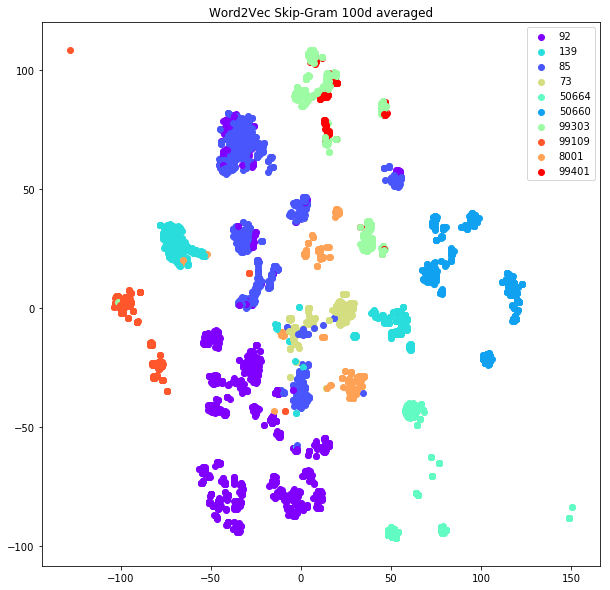

In [77]:
plot_tsne(test_docs, x_w2v_sg, y_w2v_sg, 'Word2Vec Skip-Gram 100d averaged')

{8001: 7, 50660: 2, 99109: 8, 99303: 5, 50664: 4, 73: 6, 139: 3, 85: 1, 99401: 9, 92: 0}
10 10


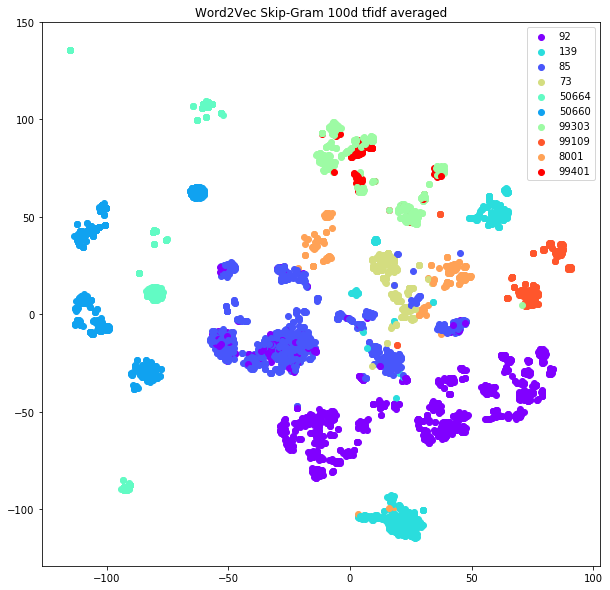

In [78]:
plot_tsne(test_docs, x_w2v_tfidf_sg, y_w2v_tfidf_sg, 'Word2Vec Skip-Gram 100d tfidf averaged')

{8001: 7, 50660: 2, 99109: 8, 99303: 5, 50664: 4, 73: 6, 139: 3, 85: 1, 99401: 9, 92: 0}
10 10


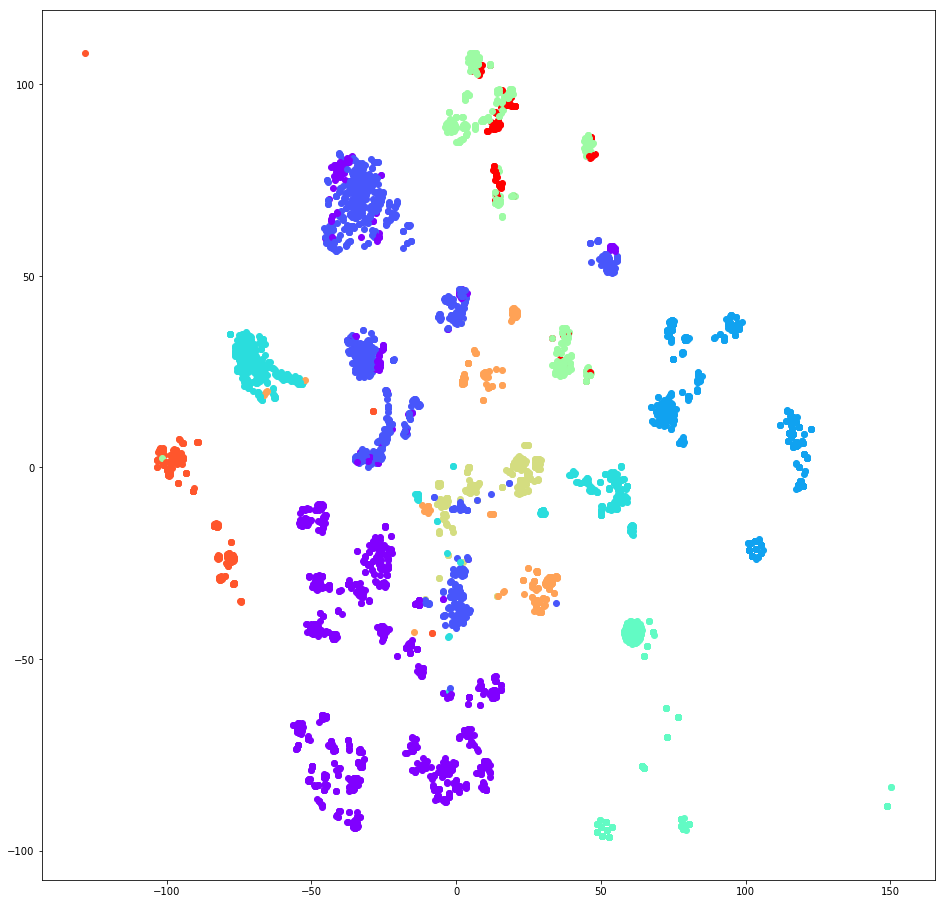

In [48]:
tsne_plot_classes(w2vmodel_stemmed, test_docs, 10, )

{8001: 8, 50660: 2, 99109: 7, 99303: 5, 50664: 4, 73: 6, 139: 3, 85: 1, 99401: 9, 92: 0}
10 10


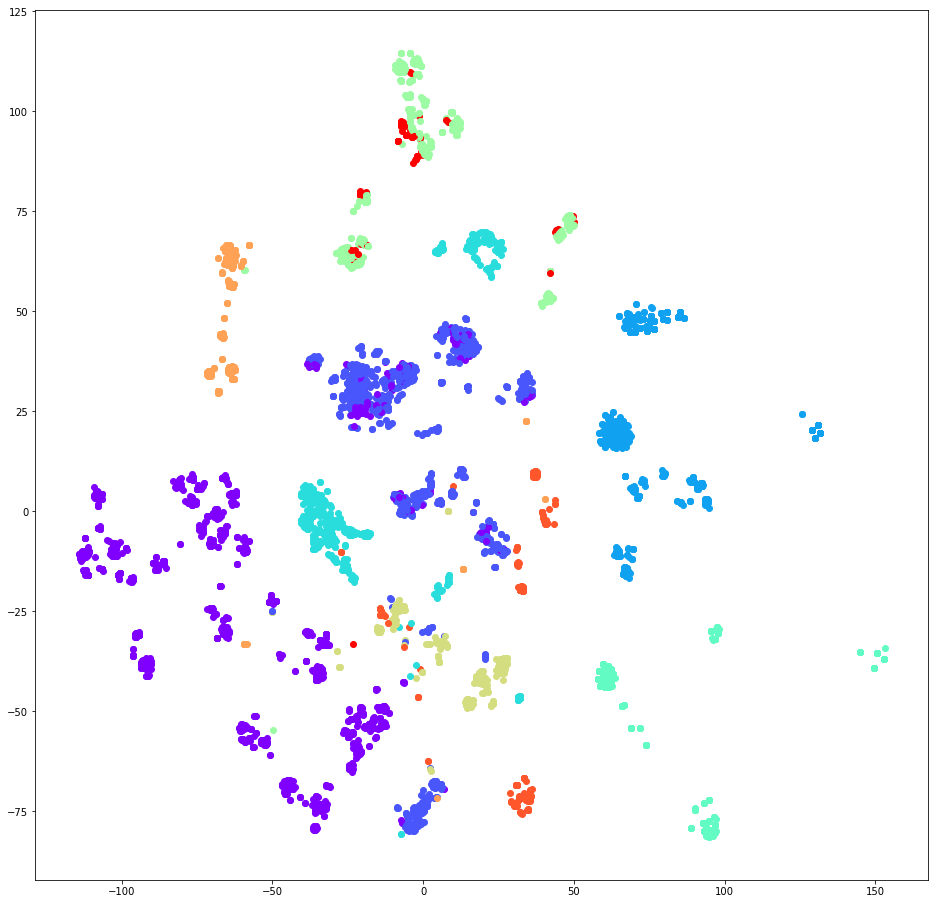

In [53]:
tsne_plot_classes(w2vmodel_stemmed, test_docs, 10)

## 4. Save everything

In [38]:
list(df_msg)

['task_name',
 'site',
 'error',
 'error_msg',
 'side_state',
 'action',
 'memory',
 'tokenized_text',
 'tokenized_text_filtered',
 'w2v']

In [52]:
out = df_msg.drop([ 'error_msg', 'side_state','action', 'memory', 'tokenized_text', 'tokenized_text_filtered' ], axis = 1)

In [53]:
def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

In [54]:
out["w2v"]= out["w2v"].apply(array_to_string)

In [55]:
out.to_csv('w2v.csv')

In [56]:
out.head()

,task_name,site,error,w2v
0,/fabozzi_Run2016D-07Aug17-v1-SingleElectron-17...,T1_US_FNAL_Disk,85,"[1.4482799,0.22476405,0.033432815,3.7562597,0...."
1,/fabozzi_Run2017B-v1-DoubleMuon-09Oct2017_940p...,T1_RU_JINR,92,"[0.9791556,2.67359,1.319544,-0.08104949,-0.393..."
2,/fabozzi_Run2017F-v1-DoubleEG-17Nov2017_940_17...,T2_UK_London_Brunel,99109,"[3.4284968,0.39303666,-1.1540284,2.4560642,-0...."
3,/fabozzi_Run2017F-v1-DoubleMuon-09May2018_947_...,T2_US_MIT,8004,"[-1.9728225,5.15743,0.5315714,4.6925755,2.0639..."
4,/fabozzi_Run2017H-v1-FSQJet2-17Nov2017_944_180...,T2_US_Nebraska,92,"[0.5495655,2.638539,1.3184719,0.3907935,-0.384..."
